<a href="https://colab.research.google.com/github/Pro-Machina/LSTM-Covid-Predictions/blob/main/Kshitij_EPI_LSTM_Final_Code_14_Day_Lead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LSTM to predict COVID-19 Cases in India
## Abstract
The COVID-19 pandemic has resulted in a significant loss of economic output and human life. A means by which to accurately forecast the spread of the disease in relation to government policy is of critical importance when determining how to minimize both the spread of disease and economic impact. The objectives of this study is to investigate the dependence of COVID-19-related deaths on the mobility habits of individuals and the government response data. The project will investigate if there are differences in the effects of incorporating the mobility and government policy data for regions of varying population density. Using the Google's mobility dataset in conjunction with The WHO dataset for COVID-19 cases and deaths as well as government response data from Oxford University to train an LSTM model, the project aims to evaluate its performance using the root mean squared error between the predicted number of cases and the actual number of cases, and compare it to an ARIMA model.

In [ ]:
!pip install --upgrade cython
!pip install --upgrade git+https://github.com/statsmodels/statsmodels

     |████████████████████████████████| 1.9 MB 2.7 MB/s 
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-rxjsh_qa
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-rxjsh_qa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev0+155.gd9f21bb96-cp37-cp37m-linux_x86_64.whl size=17880215 sha256=8ca80bd01e0f53ec0dd533fe99ffa430962e9377cec4df955b387c0a6b8a9090
  Stored in directory: /tmp/pip-ephem-wheel-cache-0vu88sma/wheels/a7/e2/12/87eac3fb9bcec178a4228e24f5d4c0996208883c6f1b44e941
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10

In [ ]:
# Import packages
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler
from torch import nn
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
import scipy
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


## Functions for Data Engineering

In [ ]:
###
def filter_dates_df(start_date, end_date, df):
  """ Extract the data corresponding to specific dates """

  if 'date' in df:
    filtered_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
  elif 'Date' in df:
    filtered_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
  elif 'Date_reported' in df:
    filtered_data = df[(df['Date_reported'] >= start_date) & (df['Date_reported'] <= end_date)]

  return filtered_data

###
def filter_covid_data(covid_df):
  """ Outputs the required dataset with required columns """

  covid_df = covid_df.fillna(0)
  covid_df = covid_df[covid_df['Country'] == 'India']
  covid_df['Date_reported'] = pd.to_datetime(covid_df['Date_reported']).dt.date
  covid_df = covid_df.drop_duplicates(subset = ['Date_reported'], keep = 'last')
  covid_df = covid_df.drop(['Country_code', 'WHO_region'], axis=1)
  covid_df = filter_dates_df(datetime.date(2020, 1, 15), datetime.date(2021, 10, 24), covid_df)

  return covid_df


def filter_mobility_data(mobility_df):
  """ Outputs the required dataset with required columns """

  # mobility_df = mobility_df.fillna(0)
  mobility_df = mobility_df[(mobility_df['place_id'] == 'ChIJkbeSa_BfYzARphNChaFPjNc')]
  mobility_df = mobility_df.fillna(method='ffill')
  mobility_df['date'] = pd.to_datetime(mobility_df['date']).dt.date
  mobility_df = filter_dates_df(datetime.date(2020, 1, 15), datetime.date(2021, 10, 24), mobility_df)

  return mobility_df

def filter_policy_data(policy_df):
  """ Outputs the required dataset with required columns """

  policy_df = policy_df.fillna(0)
  policy_df = policy_df[(policy_df['CountryName'] == 'India')]
  policy_df['Date'] = pd.to_datetime(policy_df['Date'], format='%Y%m%d').dt.date
  policy_df = filter_dates_df(datetime.date(2020, 1, 15), datetime.date(2021, 10, 24), policy_df)

  return policy_df

###
def standardize_df (df_input, target):
  """ Returns standardized data """

  df = df_input.copy()
  target_mean = df[target].mean()
  target_sd = df[target].std()

  for c in df.columns:
    mean = df[c].mean()
    sd = df[c].std()

    df[c] = (df[c] - mean)/sd
  
  df = df.fillna(0)

  return target_mean, target_sd, df

###
def scale_test_data(df_test_input, df_train_input):
  """ Standardizes the test data according to the training data """

  df_test = df_test_input.copy()
  df_train = df_train_input.copy()

  
  for c in df_test.columns:
    df_test[c] = (df_test[c] - df_train.mean(axis=0)[c])/df_train.std(axis=0)[c]

  df_test = df_test.fillna(0)
  return df_test

###
def LSTM_df (covid_df, mobility_df, policy_df, use_data = 'ALL'):
  """ Returns the data frame that can be used for LSTM input, use_data from 'ALL', 'C&D', 'MOB', 'POL' """

  reindex_df = np.linspace(1, int(covid_df.shape[0]), int(covid_df.shape[0]), dtype=int)

  covid_df = covid_df[['Date_reported', 'New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']]
  covid_df = covid_df.set_index('Date_reported')
  
  mobility_df = mobility_df[['date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]
  mobility_df = mobility_df.set_index('date')

  policy_df = policy_df[['Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6_Facial Coverings', 'H7_Vaccination policy', 'H8_Protection of elderly people']]
  policy_df = policy_df.set_index('Date')

  if use_data == 'ALL':
    lstm_df = pd.concat([covid_df, mobility_df, policy_df], axis=1)
  elif use_data == 'C&D':
    lstm_df = covid_df
  elif use_data == 'MOB':
    lstm_df = pd.concat([covid_df, mobility_df], axis=1)
  elif use_data == 'POL':
    lstm_df = pd.concat([covid_df, policy_df], axis=1)

  return lstm_df

###
def train_test_data (df, start_date, end_date, factor=0.9):
  """ Splits the data into test and train according to the input factor """
  
  no_of_days = (end_date-start_date).days

  test_data_start_date = start_date + datetime.timedelta(days=int(no_of_days*factor))
  df_train = df.loc[:test_data_start_date].copy()
  df_test = df.loc[test_data_start_date:].copy()

  return df_train, df_test

###
def get_target_features(df_input, target_col, forecast_lead):
  """ Gets the target and features from the data frame """

  df = df_input.copy()
  features = list(df.columns.difference([target_col]))
  target = f"{target_col}_lead{forecast_lead}"
  df[target] = df[target_col].shift(-forecast_lead)
  df = df.iloc[:-forecast_lead]

  return target, features, df

In [ ]:
# Creating data-loader compatible dataset
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[i].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((x, padding), 0)

        return x, self.y[i]

# Creating data-loader compatible dataset
class SequenceDatasetTest(Dataset):
    def __init__(self, dataframe, df2, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.df2 = df2
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.X_train = torch.tensor(df2[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            start = self.sequence_length - i - 1
            padding = self.X_train[-start:]
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

# Creating LSTM model
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size = num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out

###
def train_model(data_loader, model, loss_function, optimizer):
  """ Funtion for training the model """

  num_batches = len(data_loader)
  total_loss = 0
  model.train()

  for X, y in data_loader:
      output = model(X)
      loss = loss_function(output, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  avg_loss = total_loss / num_batches
  print(f"Train loss: {avg_loss}")

###
def test_model(data_loader, model, loss_function):
  """ Function for testing the model """

  num_batches = len(data_loader)
  total_loss = 0

  model.eval()
  with torch.no_grad():
      for X, y in data_loader:
        output = model(X)
        total_loss += loss_function(output, y).item()

  avg_loss = total_loss / num_batches
  print(f"Test loss: {avg_loss}")

###
def predict(data_loader, model):
  """ Uses model to predict """

  output = torch.tensor([])
  model.eval()
  with torch.no_grad():
      for X, _ in data_loader:
          y_star = model(X)
          output = torch.cat((output, y_star), 0)

  return output

In [ ]:
def mainProgram (covid_df, mobility_df, policy_df, target_prediction = 'deaths', batch_size = 4, sequence_length = 500, lead = 14, learning_rate = 5e-5, num_hidden_units = 40, epochs = 100, ar_order = 14, ma_order = 0, d = 1):
  """ The program puts everything together to give outputs of the LSTM model """

  output_LSTM_w_all = {}
  output_LSTM_w_mob = {}
  output_LSTM_w_pol = {}
  output_ARIMA = {}
  true_target = {}
  
  ### Block 1
  city_covid_df = filter_covid_data(covid_df)
  city_len = len(city_covid_df)
  
  city_mobility_data = filter_mobility_data(mobility_df)

  city_policy_data = filter_policy_data(policy_df)

  # options = ['ALL', 'MOB', 'POL']
  options = ['ALL']
  city = 'India'

  for use_data in options:

    city_lstm_df = LSTM_df(city_covid_df, city_mobility_data, city_policy_data, use_data)
    #
    city_target, city_features, city_lstm_df = get_target_features(city_lstm_df, target_prediction, forecast_lead=lead)
    split = 0.8
    city_train, city_test = train_test_data(city_lstm_df, datetime.date(2020, 1, 15), datetime.date(2021, 10, 24), split)
    city_target_mean, city_target_sd, city_train_scaled = standardize_df(city_train, city_target)
    city_test_scaled = scale_test_data(city_test, city_train)

    #
    torch.manual_seed(0)
    city_train_dataset = SequenceDataset(city_train_scaled, city_target, city_features, sequence_length)
    city_test_dataset = SequenceDatasetTest(city_test_scaled, city_train_scaled, city_target, city_features, sequence_length)

    city_train_loader = DataLoader(city_train_dataset, batch_size=batch_size)
    city_test_loader = DataLoader(city_test_dataset, batch_size=batch_size)
    
    ##
    X, y = next(iter(city_train_loader))
    model = ShallowRegressionLSTM(num_features = X.shape[2] , hidden_units=num_hidden_units)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ##
    print("Untrained test\n--------")
    test_model(city_test_loader, model, loss_function)
    print()

    for e in range(epochs):
        print(f"Epoch {e+1}\n---------")
        train_model(city_train_loader, model, loss_function, optimizer=optimizer)
        test_model(city_test_loader, model, loss_function)
        print()

    city_train_eval_loader = DataLoader(city_train_dataset, batch_size=batch_size, shuffle=False)

    ystar_col = "Model forecast"

    city_train_scaled[ystar_col] = predict(city_train_eval_loader, model).numpy()
    city_test_scaled[ystar_col] = predict(city_test_loader, model).numpy()

    df_out = pd.concat((city_train_scaled, city_test_scaled))[[city_target, ystar_col]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * city_target_sd + city_target_mean

    
    n = len(df_out['Model forecast'])
    y_pred_LSTM = list(df_out['Model forecast'][int(split*n):].values)
    print("Test RMSE for LSTM-", use_data, "for", city, '=', round(mean_squared_error(y_pred_LSTM,df_out[city_target][int(split*n):])**0.5, 3))
    print('\n')
    
    if use_data == 'ALL':
      output_LSTM_w_all[city] = y_pred_LSTM
    elif use_data == 'MOB':
      output_LSTM_w_mob[city] = y_pred_LSTM
    elif use_data == 'POL':
      output_LSTM_w_pol[city] = y_pred_LSTM

    #### ARIMA
    
  y_pred_arima = []

  new_df = city_covid_df.copy()
  # target_series is the cases/deaths for the particular state
  target_series = list(new_df[target_prediction].values)

  # splitting into history and test data
  history = list(target_series[:int(split*n)])
  test = list(target_series[int(split*n):])

  for i in range(len(test)):
    model = ARIMA(history, order=(lead,d,ma_order))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    y_pred_arima.append(yhat)
    history.append(yhat)

  rmse_arima_prev = (mean_squared_error(test, y_pred_arima))**0.5
  print("Test RMSE for ARIMA for ", city," = ", round(rmse_arima_prev,3))
  print("\n")
  
  output_ARIMA[city] = y_pred_arima

  true_target[city] = test

  return output_LSTM_w_all, output_LSTM_w_mob, output_LSTM_w_pol, output_ARIMA, true_target

## Dataset 
Three data-sets are used as input feature to LSTM. These are:


*   [COVID-19 Cases and Deaths data from WHO.](https://data.humdata.org/dataset/coronavirus-covid-19-cases-and-deaths)
*   [Google's mobility trend data.](https://www.google.com/covid19/mobility/)
*   [Oxford's COVID-19 goverment response tracker.](https://github.com/OxCGRT/covid-policy-tracker)





In [ ]:
# Covid Cases and Deaths data
covid_df = pd.read_csv("/content/drive/MyDrive/CSE 8803 EPI/WHO-COVID-19-global-data.csv")

# Mobility Data
mobility_df = pd.read_csv("/content/drive/MyDrive/CSE 8803 EPI/Global_Mobility_Report.csv")

# Policy data
policy_df = pd.read_csv("/content/drive/MyDrive/CSE 8803 EPI/OxCGRT_latest.csv")

In [ ]:
output_LSTM_w_all, output_LSTM_w_mob, output_LSTM_w_pol, output_ARIMA, true_target = mainProgram (covid_df, mobility_df, policy_df, 'New_cases', batch_size = 50, sequence_length = 500, learning_rate = 5e-5, lead = 1, num_hidden_units = 10, epochs = 300)

Untrained test
--------
Test loss: 0.027598548059662182

Epoch 1
---------
Train loss: 1.058410812507976
Test loss: 0.027500402182340622

Epoch 2
---------
Train loss: 1.055228497155688
Test loss: 0.02728888640801112

Epoch 3
---------
Train loss: 1.0524381104518066
Test loss: 0.02707364782691002

Epoch 4
---------
Train loss: 1.0496785166588696
Test loss: 0.02686041531463464

Epoch 5
---------
Train loss: 1.0469423444433645
Test loss: 0.02665022232880195

Epoch 6
---------
Train loss: 1.0442273098636756
Test loss: 0.026443148342271645

Epoch 7
---------
Train loss: 1.041531521149657
Test loss: 0.026239069799582165

Epoch 8
---------
Train loss: 1.0388537547127767
Test loss: 0.0260378485545516

Epoch 9
---------
Train loss: 1.0361929390240798
Test loss: 0.02583936384568612

Epoch 10
---------
Train loss: 1.0335482755167917
Test loss: 0.025643511054416496

Epoch 11
---------
Train loss: 1.03091933849183
Test loss: 0.025450213812291622

Epoch 12
---------
Train loss: 1.0283053947443312
T

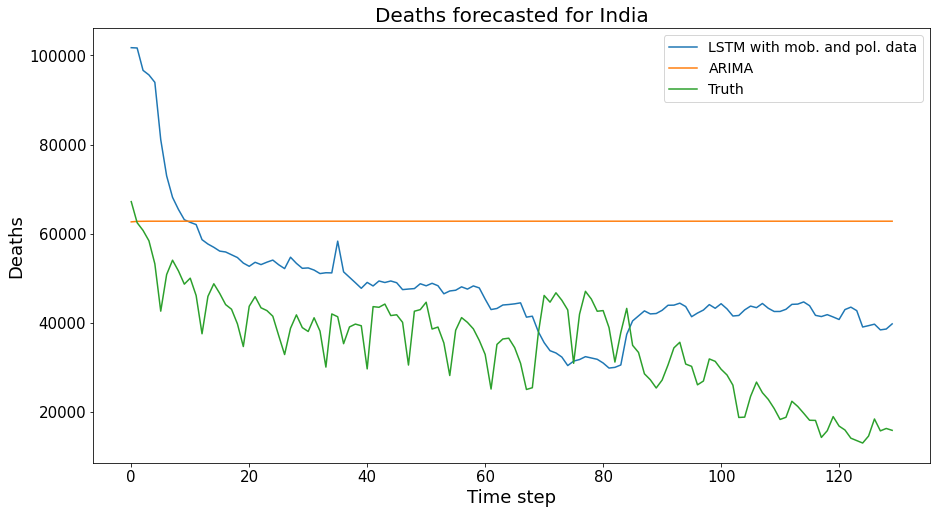

In [ ]:
# Plotting for all cities
region_list = ['India']
for city in region_list:

  y_pred_LSTM_w_all = output_LSTM_w_all[city]
  y_pred_arima = output_ARIMA[city]
  test = true_target[city]

  plt.figure(figsize=(15,8))
  plt.title("Deaths forecasted for " + str(city), fontsize = 20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel("Time step", fontsize=18)
  plt.ylabel("Deaths", fontsize=18)

  plt.plot(range(len(y_pred_LSTM_w_all)), y_pred_LSTM_w_all)
  plt.plot(range(len(y_pred_arima)), y_pred_arima)
  plt.plot(range(len(test)), test)

  legend = ['LSTM with mob. and pol. data', 'ARIMA', 'Truth']
  plt.legend(legend, fontsize=14)
  plt.show()